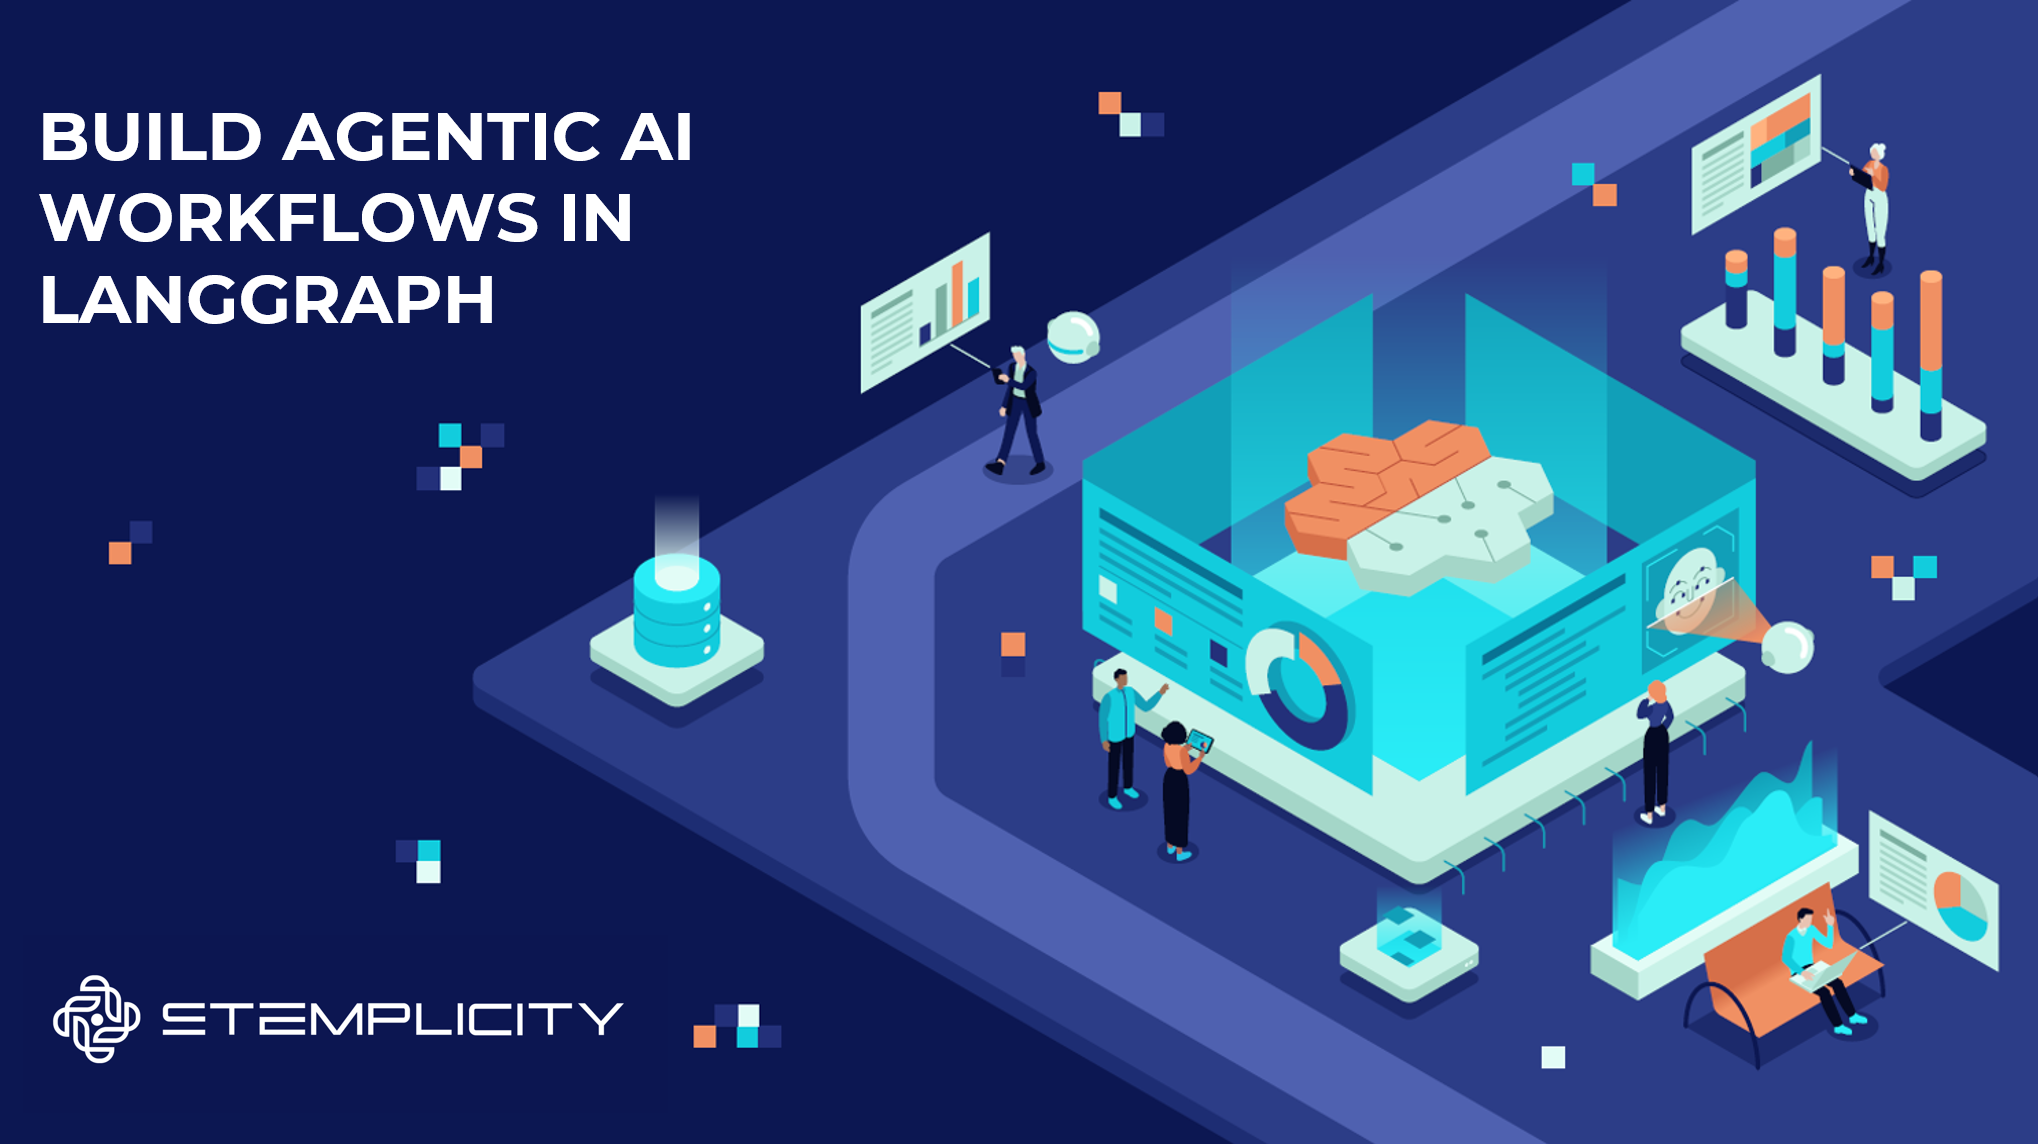

# TASK 1: PROJECT OVERVIEW: THE AI TRAVEL AGENT

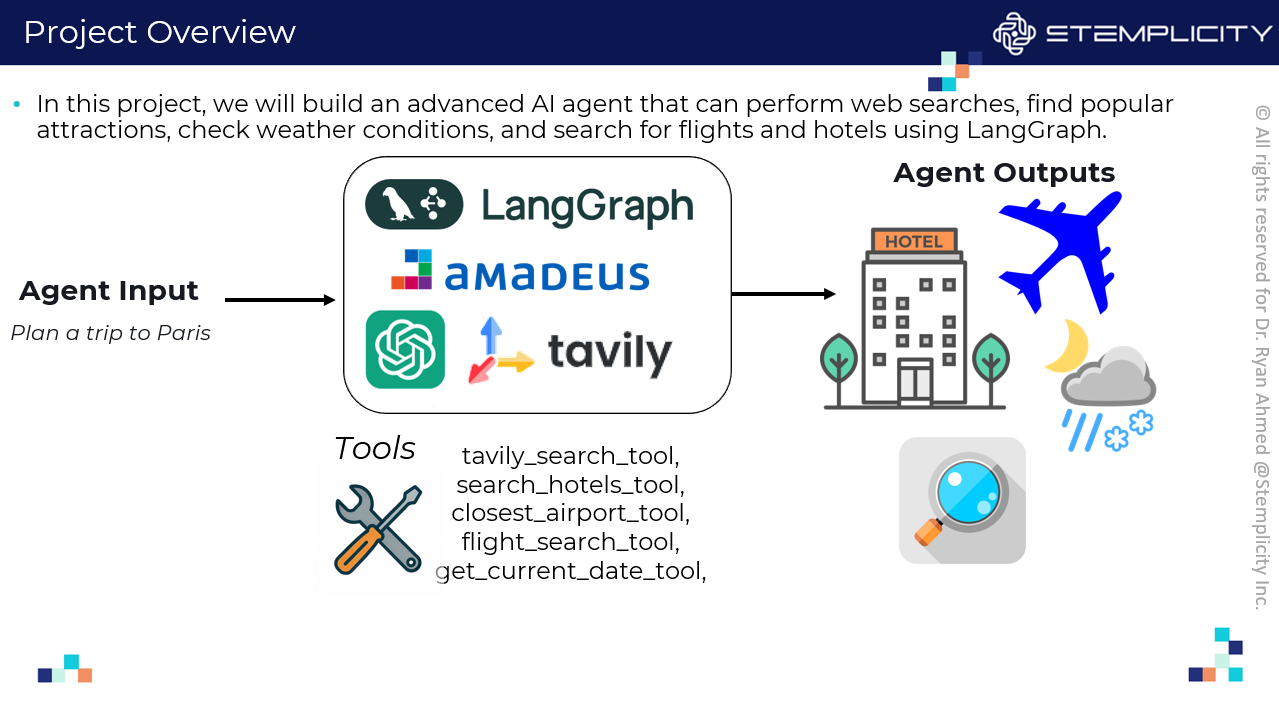

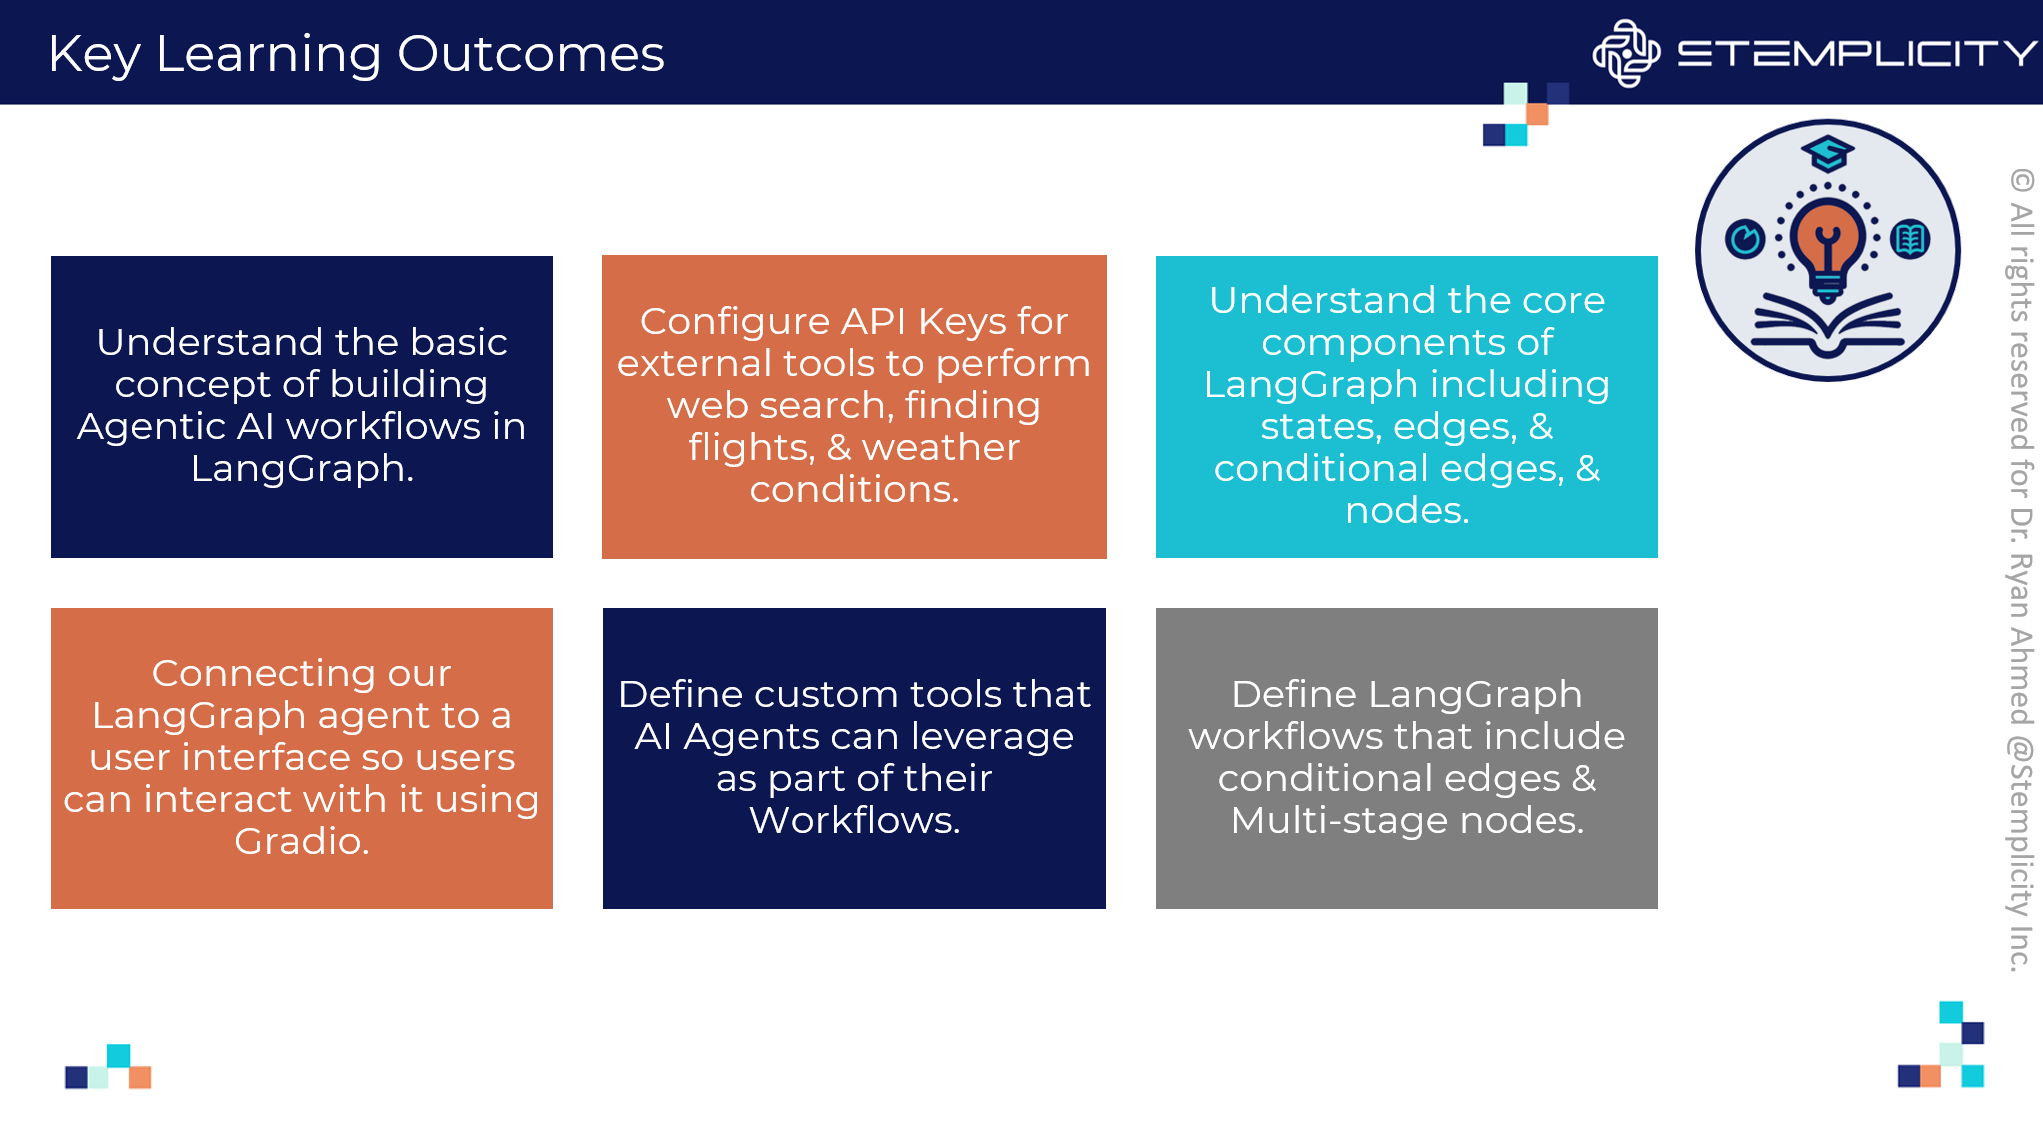

# TASK 2: UNDERSTAND LANGGRAPH & ITS KEY COMPONENTS & FEATURES 

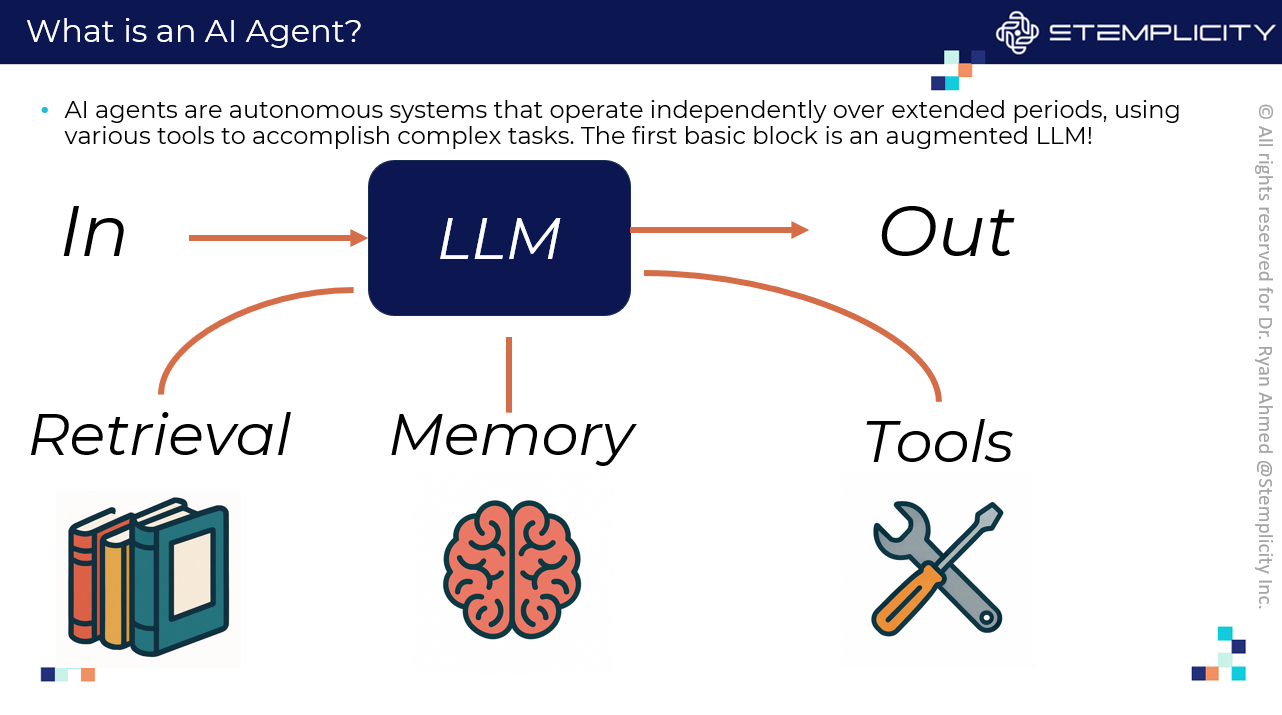

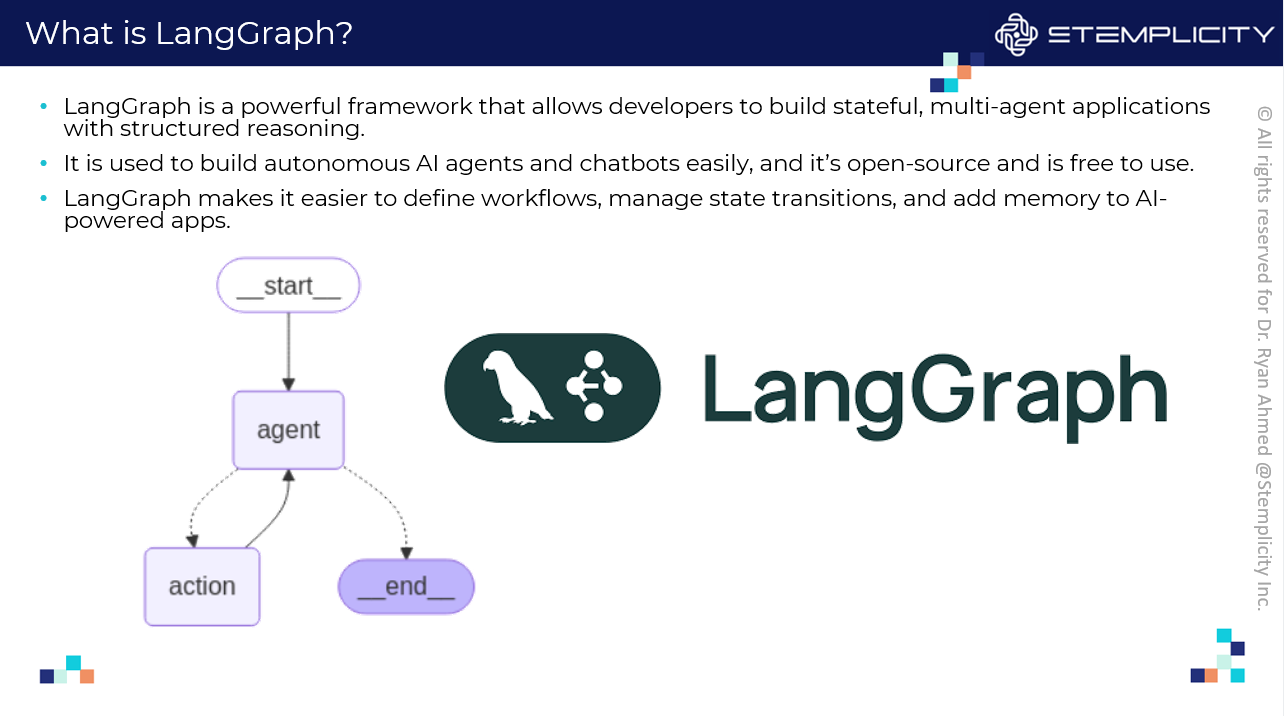

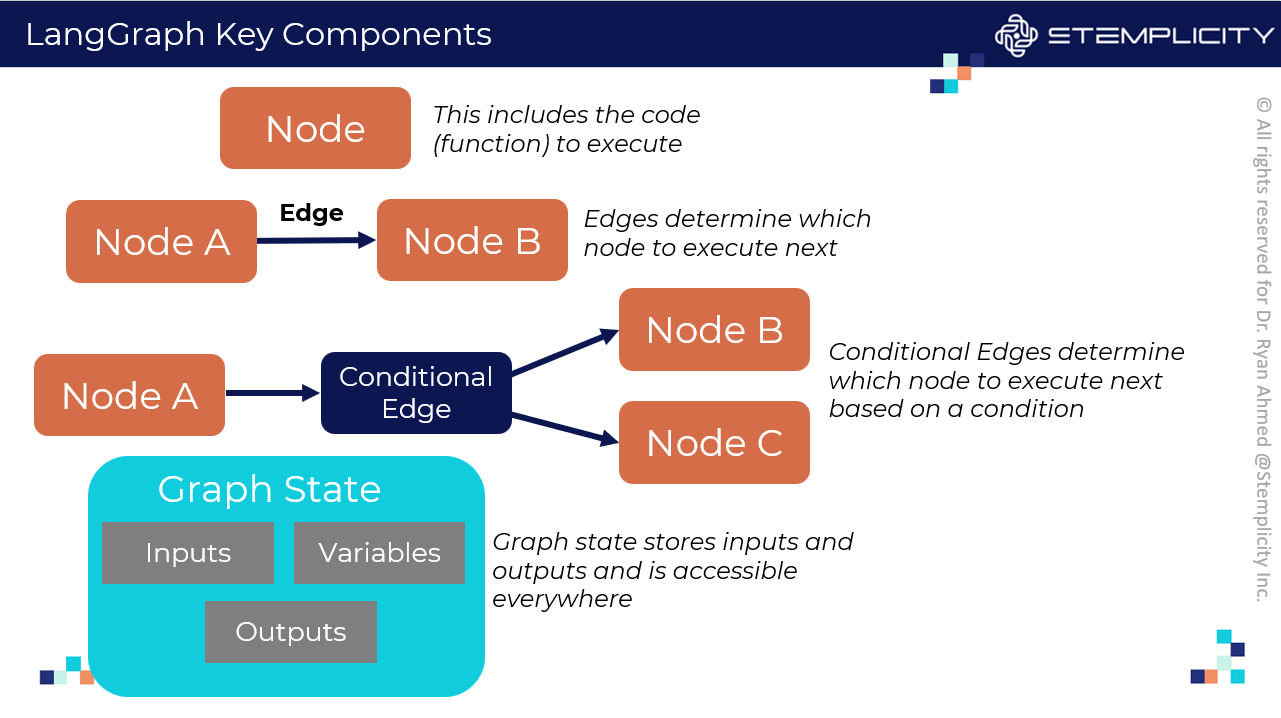

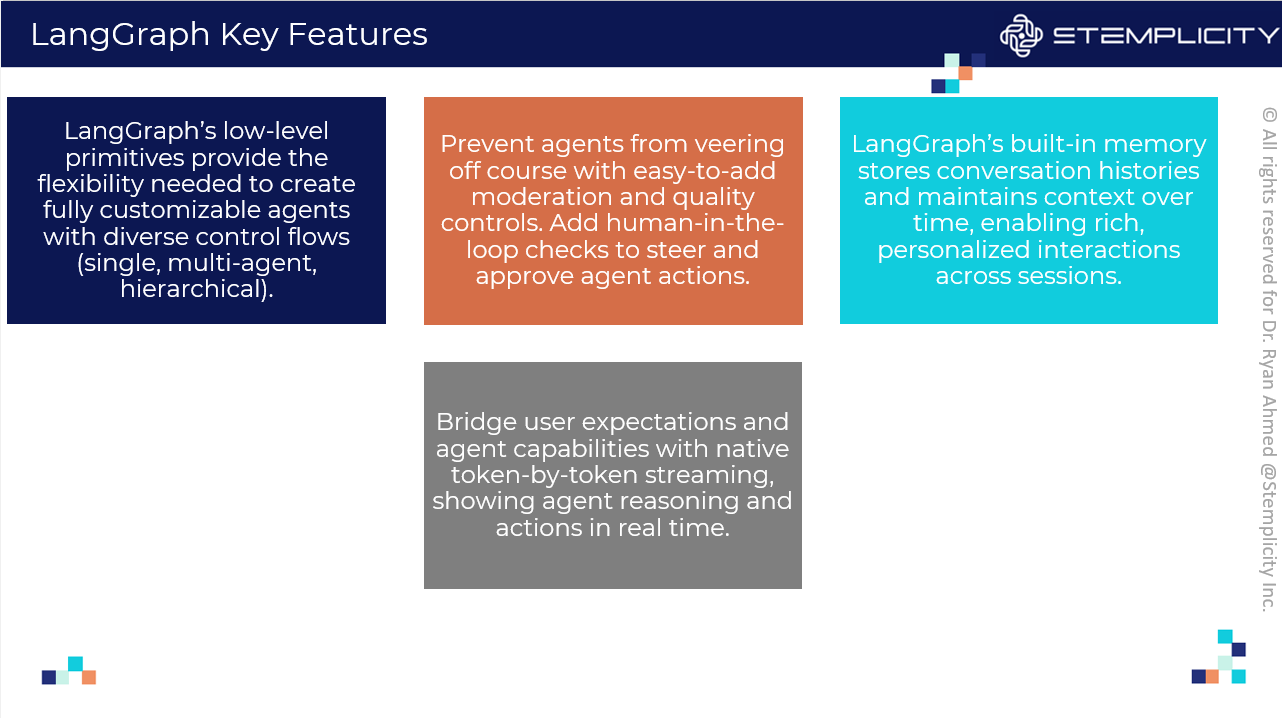

# TASK 3: BUILD OUR FIRST AGENTIC WORKFLOW IN LANGGRAPH (SUMMARIZATION AGENT) WITH NO TOOLS

LangGraph is a powerful library built on top of LangChain that focuses on creating stateful, multi-agent workflows using a graph structure. Let's start with the fundamental structure of LangGraph. We'll build a simple agent that just calls the LLM without any external tools. This helps understand the core concepts: State, Nodes, and Edges.

Key Components of LangGraph

- **StateGraph:** The core object for building workflows
- **Nodes:** Functions or agents that perform specific tasks
- **Edges:** Connections between nodes that control flow
- **State:** Information that persists across nodes
- **Conditional Routing:** Logic for determining which path to follow

In [ ]:
# Install necessary libraries
# We need langchain, langgraph, openai integration, tavily, amadeus, and gradio
!pip install -q --upgrade langchain langgraph langchain_openai tavily-python amadeus python-dotenv gradio langchain_community graphviz


In [ ]:
# Import necessary libraries
import os
import uuid
import getpass
from typing import TypedDict, Annotated, Sequence, List, Tuple, Optional, Any, Union, Literal,  Tuple
import operator
from datetime import date
from IPython.display import display, Markdown, Image
from graphviz import Source
import uuid  # Added for Gradio state

# Langchain specific imports
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage, AIMessage, SystemMessage
from langchain.tools import tool
from langchain_core.pydantic_v1 import BaseModel  # For tool args schema if needed explicitly

# LangGraph imports (Updated based on recent versions)
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode  # Preferred way to handle tool execution

# Gradio
import gradio as gr

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Set environment variables (especially useful for LangChain integrations)
openai_api_key = os.environ["OPENAI_API_KEY"]

print("API Keys loaded (partially hidden for security):")
print(f"OpenAI Key starts with: {openai_api_key[:5]}...")


In [ ]:
# Helper function to display markdown nicely
def print_markdown(text):
    """Displays text as Markdown in Jupyter."""
    display(Markdown(text))

In [ ]:
# Let's define a simple workflow that includes a summarization function
# Let's define a state that includes two information: the original text and its summary
# State is how information persists and flows between nodes
# The state is like a container that stores and passes data between different parts of our workflow
# Each node receives and returns a state object, and the State can include messages, variables, memory, etc.

class AgentState(TypedDict):
    input_text: str
    summary: str

In [ ]:
# Let's define the key node, which represents the functions that perform specific tasks in your graph
# They receive the current state and return a modified state
# Note that a node can be simple functions, LLM calls, or complex agents

def summarize_step(state: AgentState) -> AgentState:
    """Create a concise summary of the input text."""
    
    # Initialize the OpenAI model and define the prompt
    llm = ChatOpenAI(model = "gpt-3.5-turbo")
    prompt = f"Please summarize the following text in one sentence that captures the main points: {state['input_text']}"
    
    # Get the summary directly from the model
    result = llm.invoke([prompt])
    
    # Update the state with our summary
    return {
        "input_text": state["input_text"],  # Keep the original text
        "summary": result.content  # Add the summary
    }

In [ ]:
# Let's define our StateGraph, which is the fundamental building block of LangGraph
# It manages the flow of information between different components
# It maintains state throughout the execution of your workflow

# Let's define a stategraph with the "AgentState" we defined earlier
workflow = StateGraph(AgentState)

# Let's add a node, which is the summarize function we defined before
workflow.add_node("summarize", summarize_step)

# Let's define Edges, which define how data flows between nodes
workflow.add_edge("summarize", END) 
workflow.set_entry_point("summarize")
workflow.compile()

In [ ]:
# Now we are ready to compile and execute the graph 
# After defining your graph, you need to compile it to create an executable workflow
# Invoke it with an initial state to run the entire process

# Example text to summarize
sample_text = """
    Electric cars work by using electricity stored in a battery pack to power an electric motor, which drives the wheels. 
    Unlike gasoline-powered vehicles that rely on internal combustion engines, electric vehicles (EVS) use electric motors that are more efficient and produce zero emissions during operation. 
    When you press the accelerator, the battery sends power to the motor, which instantly provides torque to move the car. 
    The battery is recharged by plugging the car into an external power source, such as a home charger or public charging station. 
    Some electric cars also feature regenerative braking, which captures energy during braking and feeds it back into the battery to improve efficiency.
    """
    
# Let's compile the graph
graph = workflow.compile() 

# Set up the initial state with the input text
initial_state = {
        "input_text": sample_text,
        "summary": ""}
    
# Run the graph
result = graph.invoke(initial_state)
    
# Get the summary from the result
summary = result["summary"]
    
# Print the result
print(summary)

**PRACTICE OPPORTUNITY:**
- **Change the input message to summarize a different text:**
"The internet is a global network that connects millions of computers and devices, allowing people to share information, communicate, and access services from anywhere in the world. It works by transmitting data through a complex system of servers, cables, and wireless signals. The internet has transformed how we live, work, and learn—making it easy to search for knowledge, shop online, stream videos, use social media, and stay in touch with others. It continues to evolve, shaping nearly every aspect of modern life."

- **Rerun the workflow and assess the output**

# TASK 4: BUILD AN AGENTIC WORKFLOW IN LANGGRAPH (SUMMARIZATION + TRANSLATION AGENT) WITH NO TOOLS

In [ ]:
class AgentState(TypedDict):
    input_text: str
    summary: str
    translated_summary: str


def translate_step(state: AgentState) -> AgentState:
    """Translate text"""
    
    # Initialize the OpenAI model and define the prompt
    llm = ChatOpenAI(model = "gpt-4o-mini")
    prompt = f"Please translate from english to spanish: {state['summary']}"
    
    # Get the summary directly from the model
    result = llm.invoke([prompt])
    
    # Update the state with our summary
    return {
        "input_text": state["input_text"],  # Keep the original text
        "summary": state["summary"],  # Add the summary
        "translated_summary": result.content
    }


# Let's define a stategraph with the "AgentState" we defined earlier
workflow = StateGraph(AgentState)

# Let's add a node, which is the summarize function we defined before
workflow.add_node("summarize", summarize_step)

# Let's define Edges, which define how data flows between nodes
workflow.add_edge("summarize", "translate") 

workflow.add_node("translate", translate_step)

workflow.set_entry_point("summarize")
workflow.compile()

In [ ]:
# Example text to summarize
sample_text = """
    Electric cars are awesome! I love them so much! They work by using electricity stored in a battery pack to power an electric motor, which drives the wheels. 
    Unlike gasoline-powered vehicles that rely on internal combustion engines, electric vehicles (EVS) use electric motors that are more efficient and produce zero emissions during operation. 
    When you press the accelerator, the battery sends power to the motor, which instantly provides torque to move the car. 
    The battery is recharged by plugging the car into an external power source, such as a home charger or public charging station. 
    Some electric cars also feature regenerative braking, which captures energy during braking and feeds it back into the battery to improve efficiency.
    """
    
# Let's compile the graph
graph = workflow.compile() 

# Set up the initial state with the input text
initial_state = {
        "input_text": sample_text,
        "summary": "",
        "translated_summary": ""}
    
# Run the graph
result = graph.invoke(initial_state)
    
# Get the summary from the result
summary = result["summary"]
translation = result["translated_summary"]

# Print the results with clear labels and spacing
print("=== Generated Summary ===")
print(summary)

print("\n=== Translated Summary ===")
print(translation)

**PRACTICE OPPORTUNITY:**
- **Define a new function called sentiment_step(state: AgentState) -> AgentState. This function uses language models to classify the translated text as either positive, negative, or neutral.**
- **Update the AgentState and Graph to include a new "analyze_sentiment" node.**

# TASK 5: LANGGRAPH WITH SINGLE TOOL (WEB SEARCH) USING TOOLNODE & CONDITIONAL EDGE

Now, let's give our agent its first superpower: the ability to search the web using the Tavily tool. We'll `ToolNode` for handling tool execution.

**Changes:**

1.  **Tool Definition:** Define the `tavily_search_tool`.
2.  **Nodes:**
    *   Define `call_model_with_tools` node that binds the tool(s) to the LLM.
    *   Instantiate `ToolNode`: Create an instance of `ToolNode` with our list of tools.
3.  **Conditional Edge:** Use the `should_continue` function (which checks the last message for tool calls) to direct the flow.
4.  **Graph Construction:**
    *   Add the `call_model_with_tools` node ("agent").
    *   Add the instantiated `ToolNode` as the "action" node.
    *   Set the entry point to "agent".
    *   Add the conditional edge from "agent" based on `should_continue` to either "action" or `END`.
    *   Add a direct edge from "action" back to "agent".

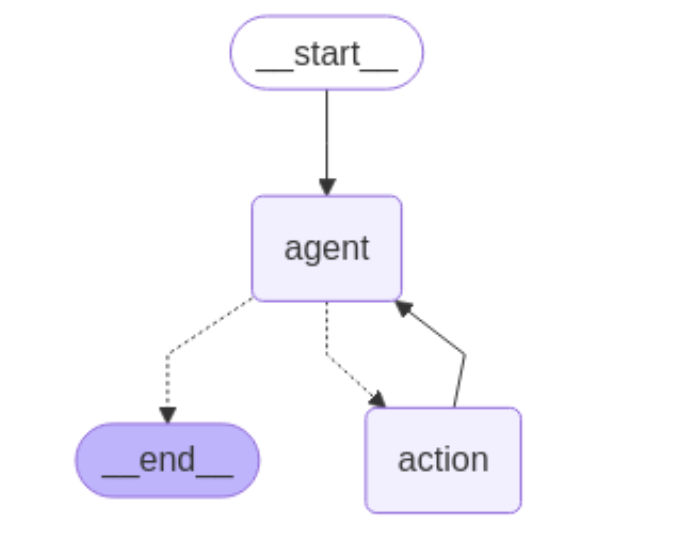

**Tavily AI:** For efficient web searches ([https://tavily.com/](https://tavily.com/)).

**Action:**

1.  Sign up for Tavily Self-Service API if you haven't already.
2.  Create a `.env` file in the same directory as this notebook (if you don't have one).
3.  Add your keys to the `.env` file like this:

```dotenv
OPENAI_API_KEY=sk-YourSecretOpenAIKey...
TAVILY_API_KEY=tvly-YourSecretTavilyKey...
```

Let's install the necessary libraries and load the keys.

In [ ]:
tavily_api_key = os.environ["TAVILY_API_KEY"]
print(f"Tavily Key starts with: {tavily_api_key[:5]}...")

In [ ]:
# Configure the OpenAI Client (using LangChain's wrapper)
# We use GPT-4o as it's generally better with tool calling
llm = ChatOpenAI(model = "gpt-4.1-mini", temperature = 0, streaming = True)
print("LangChain OpenAI Chat Model configured.")

In [ ]:
# Define the Agent State
class AgentState(TypedDict):
    # AgentState is the name of the dictionary (used to represent the agent's state in the workflow).
    # It has one key: "messages", which holds a list of messages (e.g., from the user, model, or tools).
    # BaseMessage is the type used to represent each message in that list.
    # operator.add tells LangGraph to append new messages to the list during execution.
    messages: Annotated[Sequence[BaseMessage], operator.add]


In [ ]:
# Let's set up our search tool that fetches results from Tavily (a search engine wrapper)
# Setting max_results to 3 limits the number of search results.

from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search_tool = TavilySearchResults(max_results = 3)

# List of tools for this step
tools_list_single = [tavily_search_tool]

In [ ]:
# Let's define call_model_with_tools node that binds the tool(s) to the LLM.
# This format is useful when you want to reuse the same model logic with different tools.
# You're building modular, reusable parts for your AI workflow (like LangGraph nodes).
# The Outer function (make_call_model_with_tools(tools)):
# It knows about the tools and returns a customized inner function.

# Inner function (call_model_with_tools(state)): This is the execution function. 
# It knows how to use the current state (conversation history) and actually runs the model with the tools that were set up by the outer function.

def make_call_model_with_tools(tools: list):
    def call_model_with_tools(state: AgentState):
        print("DEBUG: Entering call_model_with_tools node")
        messages = state["messages"]
        
        # Binds the tools to the language model 
        model_with_tools = llm.bind_tools(tools)

        # Feeds the conversation history (messages) into the model
        response = model_with_tools.invoke(messages)

        # Return the model response as a new message
        return {"messages": [response]}

    return call_model_with_tools


In [ ]:
# Let's Define Conditional Edge Logic
# This function checks the most recent message in the state and decides whether to route to the 'action' node (ToolNode) or end.
# This function is used to control the flow of your agent, it's like a traffic signal deciding where to send the agent next.
# The function should_continue checks the last message in the agent's memory and decides:
# If the message includes a tool call, it routes to the next step (the action node, where the tool is actually used).
# If there's no tool call, it ends the conversation (__end__).


def should_continue(state: AgentState) -> Literal["action", "__end__"]:
    """Determines the next step: continue with tools or end."""
    print("DEBUG: Entering should_continue node")
    last_message = state["messages"][-1]
    
    # Check if the last message is an AIMessage with tool_calls
    if isinstance(last_message, AIMessage) and hasattr(last_message, "tool_calls") and last_message.tool_calls:
        print("DEBUG: Decision: continue (route to action)")
        return "action"  # Route to the node named "action"
    else:
        print("DEBUG: Decision: end (route to END)")
        return END  # Special value indicating the end of the graph

In [ ]:
# ToolNode is a prebuilt ready-to-use node from LangGraph that is specifically designed to run external tools 
# like search, calculator, database query
from langgraph.prebuilt import ToolNode  

def build_graph_one_tool(tools_list):

    # Let's Instantiate ToolNode
    tool_node = ToolNode(tools_list)

    # Define the call_node_fn, which binds the tools to the LLM and calls OpenAI API
    call_node_fn = make_call_model_with_tools(tools_list)       

    # Build the Graph with One Tool using ToolNode
    graph_one_tool = StateGraph(AgentState)

    # Add nodes
    graph_one_tool.add_node("agent", call_node_fn)
    
    # Add the ToolNode instance directly, naming it "action"
    graph_one_tool.add_node("action", tool_node)

    # Set entry point
    graph_one_tool.set_entry_point("agent")

    # Add a conditional edge from the agent
    # The dictionary maps the return value of 'should_continue' ("action" or END)
    # to the name of the next node ("action" or the special END value).
    graph_one_tool.add_conditional_edges(
        "agent",  # Source node name
        should_continue,  # Function to decide the route
        {"action": "action", END: END},  # Mapping: {"decision": "destination_node_name"}
    )

    # Add edge from action (ToolNode) back to agent
    graph_one_tool.add_edge("action", "agent")

    # Compile the graph
    app = graph_one_tool.compile()

    # Visualize
    display(Image(app.get_graph().draw_mermaid_png()))

    return app

In [ ]:
def app_call(app, messages):
    # Initialize the state with the provided messages
    initial_state = {"messages": [HumanMessage(content=messages)]}

    # Invoke the app with the initial state
    final_state = app.invoke(initial_state)

    # Iterate through the messages in the final state
    for i in final_state["messages"]:
        # Print the type of the message in markdown format
        print_markdown(i.type)
        # Print the content of the message in markdown format
        print_markdown(i.content)
        # Print any additional kwargs associated with the message
        if i.additional_kwargs != {}:
            print(i.additional_kwargs)

    # Return the content of the last message and the final state
    return final_state["messages"][-1].content, final_state

In [ ]:
app = build_graph_one_tool(tools_list_single)

In [ ]:
messages = "What's the latest news on France in May 2025? Is it a good time to visit?"
output, history = app_call(app, messages)

print("\n==================== OUTPUT ====================")
print(output)

print("\n==================== HISTORY ===================")
print(history)

**PRACTICE OPPORTUNITY:**
- **Change the input message to something that shouldn't require web search (e.g., "What is 2 + 2?"**.
- **Rerun the test section of the code cell above.**
- **Observe the DEBUG logs and Streaming output:**
  - **Does the `agent` node still run?** 
  - **Does `call_model_with_tools` show any `LLM Tool Calls`?** 
  - **Does the `should_continue` node decide to `end`?** 
  - **Does the `action` node (ToolNode) run?**

# TASK 6: CREATE AND ADD A CUSTOM NEW TOOL

**Goal:** Show how to wrap any Python function as a LangChain tool so it can be automatically discovered and invoked by your agent.

In [ ]:
@tool
def get_current_date_tool():
    """Returns the current date in 'YYYY-MM-DD' format. Useful for finding flights/hotels relative to today."""
    return date.today().isoformat()


app_current_date = build_graph_one_tool([get_current_date_tool])

# Prepare your input

prompt = "What is the current date?"
output, history = app_call(app_current_date, prompt)

**PRACTICE OPPORTUNITY:** 
- **Come up with a new tool that the AI agent can use to do addition and subtraction.**
- **Add the tool to the list of tools and test the agent with the new tool.**

# TASK 7: LEVERAGE LANGGRAPH TO PERFORM FLIGHT SEARCH USING AMADEUS & `ToolNode`

Our Travel Agent needs access to several services:


*   **OpenAI:** For the core LLM reasoning.
*   **Amadeus:** For flight data. Requires API Key and Secret ([https://developers.amadeus.com/](https://developers.amadeus.com/)). Free test environment available.


**Action:**

1.  Sign up for Tavily and Amadeus Self-Service APIs if you haven't already.
2.  Create a `.env` file in the same directory as this notebook (if you don't have one).
3.  Add your keys to the `.env` file like this:

```dotenv
AMADEUS_CLIENT_ID=YourAmadeusClientID...
AMADEUS_CLIENT_SECRET=YourAmadeusSecret...
```

Let's install the necessary libraries and load the keys.


In [ ]:
# Load environment variables
from dotenv import load_dotenv
load_dotenv()

amadeus_api_key = os.environ["AMADEUS_CLIENT_ID"]
amadeus_api_secret = os.environ["AMADEUS_CLIENT_SECRET"]
print(f"Amadeus Key starts with: {amadeus_api_key[:5]}...")
print(f"Amadeus Secret starts with: {amadeus_api_secret[:5]}...")

In [ ]:
# Service clients
from amadeus import Client, ResponseError

# Configure Amadeus Client
# We'll only initialize it if keys are provided, inside the tool later
amadeus_client = Client(
    client_id = amadeus_api_key,
    client_secret = amadeus_api_secret,
    hostname = "test",  # Start with the test environment
)


In [ ]:
@tool
def search_flights_tool(
    origin_code: str,
    destination_code: str,
    departure_date: str,
    return_date: str | None = None,
    adults: int = 1,
    travel_class: str = "ECONOMY",
    currency: str = "USD",
    max_offers: int = 5,
):
    """
    Searches live flight prices and availability via Amadeus Flight Offers Search API.
    Required:
        origin_code, destination_code – IATA airport/city codes (e.g., 'YYZ', 'LHR')
        departure_date – 'YYYY-MM-DD'
    Optional:
        return_date – for round‑trips; omit for one‑way
        adults – number of adult passengers (default 1)
        travel_class – 'ECONOMY', 'PREMIUM_ECONOMY', 'BUSINESS', 'FIRST'
        currency – 3‑letter code for pricing (default USD)
        max_offers – how many offers to list back
    """

    print(
        f"DEBUG: Calling Amadeus Flight Search – "
        f"{origin_code}->{destination_code}, "
        f"Depart {departure_date}, Return {return_date}, "
        f"Adults {adults}, Class {travel_class}"
    )

    # --- Call Amadeus Flight Offers Search API ---
    flight_search_params = {
        "originLocationCode": origin_code,
        "destinationLocationCode": destination_code,
        "departureDate": departure_date,
        "adults": adults,
        "travelClass": travel_class,
        "currencyCode": currency,
        "max": max_offers,
    }
    if return_date:
        flight_search_params["returnDate"] = return_date

    response = amadeus_client.shopping.flight_offers_search.get(**flight_search_params)

    # --- Parse the response ---
    if not response.data:
        return (
            f"No flight offers found for {origin_code} → {destination_code} on "
            f"{departure_date}{' (return '+return_date+')' if return_date else ''}."
        )

    results = []
    for offer in response.data[:max_offers]:
        price = offer["price"]["total"]
        airline = offer["validatingAirlineCodes"][0]
        itinerary = offer["itineraries"][0]
        segments = itinerary["segments"]
        first_leg = segments[0]
        last_leg = segments[-1]
        dep_time = first_leg["departure"]["at"][:16].replace("T", " ")
        arr_time = last_leg["arrival"]["at"][:16].replace("T", " ")
        duration = itinerary["duration"].replace("PT", "")
        results.append(f"{airline} | {dep_time} → {arr_time} | {duration} | {price} {currency}")

    return "Found flight options:\n- " + "\n- ".join(results)


# Create Flight SearchTools List
tools_list_full = [
    get_current_date_tool,
    search_flights_tool,
]

app_flight_search = build_graph_one_tool(tools_list_full)

In [ ]:
# Prepare your input
prompt = "I want to go to Paris from Toronto for the first week of June. Can you find flight options for 2 adults?"
output, history = app_call(app_flight_search, prompt)

print("\n==================== OUTPUT ====================")
print(output)

print("\n==================== HISTORY ===================")
print(history)

**PRACTICE OPPORTUNITY:** 
- **Similar to how we built the flight search tool, build a tool to search for hotels in NYC.**
- **Modify the tool list to achieve this and test the pipeline using the following check-in and check-out dates 2025-10-01 to 2025-10-03.**

# TASK 8: BRINGING IT ALL TOGETHER AND BUILD THE TRAVEL BOOKING AGENT

In [ ]:
tools = [
    tavily_search_tool,
    search_flights_tool,
    get_current_date_tool,
]

app_travel_agent = build_graph_one_tool(tools)

# Prepare your input
prompt = "I want the latest news about New York, I'm planning to visit from 2025-06-01 to 2025-06-04, leaving from Toronto. Please fetch security and travel advisories, find the cheapest flight for one adult. Finally, format the combined output."
output, history = app_call(app_travel_agent, prompt)

In [ ]:
print_markdown(output)

**PRACTICE OPPORTUNITY:** 
- **Assume that you plan to visit Paris in July. Test the tool to get obtain the latest news and find flights.**
- *Note that Amadeus free tool might have limited hotel search capability*

# TASK 9: INTEGRATING WITH GRADIO

Now we have our powerful, multi-tool LangGraph agent. Let's connect it to a Gradio `ChatInterface` for user interaction.

In [ ]:
def travel_agent_chat(user_input: str, history=None):
    tools_used = []
    stream = app_travel_agent.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config={"recursion_limit": 15, "configurable": {"thread_id": str(uuid.uuid4())}},
    )

    # 1) Stream in tool calls and model tokens
    for chunk in stream:
        _, node = next(iter(chunk.items()))
        if isinstance(node, dict) and "messages" in node:
            for msg in node["messages"]:
                if isinstance(msg, ToolMessage):
                    if msg.name not in tools_used:
                        tools_used.append(msg.name)
                    yield f"\n\n **Tool:** {msg.name}\n{msg.content}\n\n—\n\n"
                elif isinstance(msg, AIMessage) and msg.content:
                    yield msg.content

    # 2) After streaming completes, yield a recap
    if tools_used:
        yield f"\n\n**Tools used this session:** {', '.join(tools_used)} \n\n — \n\n {msg.content}"



travel_chatbot_interface = gr.ChatInterface(
    fn = travel_agent_chat,
    chatbot = gr.Chatbot(
        height = 650,
        label = "AI Travel Agent",
        show_copy_button = True,
        bubble_full_width = False,
        render_markdown = True,
    ),
    
    textbox = gr.Textbox(
        placeholder = "Plan your trip! Ask about attractions, flights, hotels...", container = False, scale = 7
    ),
    title = "✈️ LangGraph AI Travel Agent 🌍",
    description = "Your stateful travel assistant…",
    examples = [
        ["What are the top 3 tourist attractions in Tokyo (HND)?"],
        ["Find flights from London (LHR) to Paris (CDG) leaving next month for 4-day trip"],
        ["Book a hotel for 5 nights in NYC next month"],
    ],
    cache_examples = False,
)

travel_chatbot_interface.launch()

# PRACTICE OPPORTUNITIES SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:**
- **Change the input message to summarize a different text:**
"The internet is a global network that connects millions of computers and devices, allowing people to share information, communicate, and access services from anywhere in the world. It works by transmitting data through a complex system of servers, cables, and wireless signals. The internet has transformed how we live, work, and learn—making it easy to search for knowledge, shop online, stream videos, use social media, and stay in touch with others. It continues to evolve, shaping nearly every aspect of modern life."

- **Rerun the workflow and assess the output**

In [ ]:
sample_text = """The internet is a global network that connects millions of computers and devices, allowing people to share information, communicate, and access services from anywhere in the world. 
It works by transmitting data through a complex system of servers, cables, and wireless signals. 
The internet has transformed how we live, work, and learn—making it easy to search for knowledge, shop online, 
stream videos, use social media, and stay in touch with others. It continues to evolve, shaping nearly every aspect of modern life."""

# Let's compile the graph
graph = workflow.compile() 

# Set up the initial state with the input text
initial_state = {
        "input_text": sample_text,
        "summary": ""}
    
# Run the graph
result = graph.invoke(initial_state)
    
# Get the summary from the result
summary = result["summary"]
    
# Print the result
print(summary)


**PRACTICE OPPORTUNITY SOLUTION:**
- **Define a new function called sentiment_step(state: AgentState) -> AgentState. This function uses language models to classify the translated text as either positive, negative, or neutral.**
- **Update the AgentState and Graph to include a new "analyze_sentiment" node.**

In [ ]:
# Define the shared state structure
class AgentState(TypedDict):
    input_text: str
    summary: str
    translated_summary: str
    sentiment: str  # <- state key

# Summarize step
def summarize_step(state: AgentState) -> AgentState:
    llm = ChatOpenAI(model="gpt-4o-mini")
    prompt = f"Summarize this text:\n\n{state['input_text']}"
    result = llm.invoke([prompt])
    return {
        **state, # The syntax **state in Python means you're unpacking a dictionary — spreading out its key-value pairs.
        # Take everything from state (like "input_text", "summary", etc.). Then overwrite the "sentiment" key with a new value
        "summary": result.content
    }

# Translate step
def translate_step(state: AgentState) -> AgentState:
    llm = ChatOpenAI(model="gpt-4o-mini")
    prompt = f"Please translate from English to Spanish: {state['summary']}"
    result = llm.invoke([prompt])
    return {
        **state,
        "translated_summary": result.content
    }

# Sentiment step
def sentiment_step(state: AgentState) -> AgentState:
    llm = ChatOpenAI(model="gpt-4o-mini")
    prompt = f"Classify the sentiment of the following text as positive, negative, or neutral:\n\n{state['input_text']}"
    result = llm.invoke([prompt])
    return {
        **state,
        "sentiment": result.content.strip()
    }

# Define the graph
workflow = StateGraph(AgentState)

# Add nodes (use unique names)
workflow.add_node("summarize", summarize_step)
workflow.add_node("translate", translate_step)
workflow.add_node("analyze_sentiment", sentiment_step)  # Renamed to avoid conflict

# Define edges
workflow.add_edge("summarize", "translate")
workflow.add_edge("translate", "analyze_sentiment")  # Use renamed node

# Set entry point
workflow.set_entry_point("summarize")

# Compile the graph
graph = workflow.compile()

# Sample input
sample_text = """
Electric cars work by using electricity stored in a battery pack to power an electric motor, which drives the wheels. 
Unlike gasoline-powered vehicles that rely on internal combustion engines, electric vehicles (EVs) use electric motors that are more efficient and produce zero emissions during operation. 
When you press the accelerator, the battery sends power to the motor, which instantly provides torque to move the car. 
The battery is recharged by plugging the car into an external power source, such as a home charger or public charging station. 
Some electric cars also feature regenerative braking, which captures energy during braking and feeds it back into the battery to improve efficiency.
"""

# Initial state
initial_state = {
    "input_text": sample_text,
    "summary": "",
    "translated_summary": "",
    "sentiment": ""
}

# Run the workflow
result = graph.invoke(initial_state)

# Display results
print("=== Generated Summary ===")
print(result["summary"])

print("\n=== Translated Summary ===")
print(result["translated_summary"])

print("\n=== Sentiment ===")
print(result["sentiment"])

**PRACTICE OPPORTUNITY SOLUTION:**
- **Change the input message to something that shouldn't require web search (e.g., "What is 2 + 2?"**.
- **Rerun the test section of the code cell above.**
- **Observe the DEBUG logs and Streaming output:**
  - **Does the `agent` node still run?** 
  - **Does `call_model_with_tools` show any `LLM Tool Calls`?** 
  - **Does the `should_continue` node decide to `end`?** 
  - **Does the `action` node (ToolNode) run?**

In [ ]:
messages = "What is 2 + 2?"
output, history = app_call(app, messages)

print("\n==================== OUTPUT ====================")
print(output)

print("\n==================== HISTORY ===================")
print(history)

# Expected Observation:
# 1. DEBUG logs for 'call_model_with_tools' should show the LLM response, but NO tool calls requested.
# 2. DEBUG logs for 'should_continue' should show "Decision: end".
# 3. The 'action' node (ToolNode) should NOT be executed.
# 4. The final response should be the direct answer from the LLM (e.g., "4" or the story).
# This confirms the agent correctly bypasses the tool when the query doesn't warrant its use based on description/context.

**PRACTICE OPPORTUNITY SOLUTION:**
- **Come up with a new tool that the agent can use to do addition and subtraction.**
- **Add the tool to the list of tools and test the agent with the new tool.**

In [ ]:
# 1. Define the Math Tool
@tool
def simple_math_tool(operand1: float, operand2: float, operation: Literal["add", "subtract"]):
    """
    Performs simple addition or subtraction on two numbers.
    Specify 'add' or 'subtract' for the operation.
    """
    print(f"DEBUG: Executing Math Tool: {operand1} {operation} {operand2}")
    if operation == "add":
        result = operand1 + operand2
        return f"The result of {operand1} + {operand2} is {result}"
    elif operation == "subtract":
        result = operand1 - operand2
        return f"The result of {operand1} - {operand2} is {result}"
    else:
        return "Invalid operation specified. Use 'add' or 'subtract'."


# 2. Build a graph specifically for this tool (or add it to another list)
tools_list_po = [simple_math_tool]
app_po = build_graph_one_tool(tools_list_po)
print("\nGraph built for Math Tool.")

# 3. Test with math queries
query_add = "What is 123.5 + 456.7?"
print(f"\nTesting Math Tool (Query: '{query_add}')...")
output_add, _ = app_call(app_po, query_add)
print("\n--- Final Output (Addition) ---")
print_markdown(output_add)


In [ ]:
query_subtract = "Calculate 100 minus 33.3"
print(f"\nTesting Math Tool (Query: '{query_subtract}')...")
output_subtract, _ = app_call(app_po, query_subtract)
print("\n--- Final Output (Subtraction) ---")
print_markdown(output_subtract)

# Expected Observation:
# - For both queries, the agent should identify the need for 'simple_math_tool'.
# - The DEBUG logs should show the correct operands and operation being passed.
# - The final output should contain the calculated result from the tool.

**PRACTICE OPPORTUNITY SOLUTION:** 
- **Similar to how we built the flight search tool, build a tool to search for hotels in NYC.**
- **Modify the tool list to achieve this and test the pipeline using the following check-in and check-out dates 2025-10-01 to 2025-10-03.**

In [ ]:

@tool
def search_hotels_tool(city_code: str, check_in_date: str, check_out_date: str, adults: int = 1):
    """
    Searches for available hotel options in a specific city for given dates using Amadeus.
    Requires the IATA city code (e.g., 'PAR', 'BER') and dates in 'YYYY-MM-DD' format. Use get_current_date_tool first if dates are relative.
    """

    print(
        f"DEBUG: Calling Amadeus Hotel Search - City: {city_code}, Check-in: {check_in_date}, Check-out: {check_out_date}, Adults: {adults}"
    )
    # Call Amadeus API - Hotel Search (find hotels by city)
    hotel_list_response = amadeus_client.reference_data.locations.hotels.by_city.get(
        cityCode=city_code, radius=50, radiusUnit="KM"
    )

    if not hotel_list_response.data or len(hotel_list_response.data) == 0:
        return f"No hotels found listed in Amadeus for city code {city_code}."

    # Get hotel IDs from the response (limit to first 5 for offers search)
    hotel_ids = [hotel["hotelId"] for hotel in hotel_list_response.data[:5]]

    # Now search for offers for these specific hotels
    hotel_offer_response = amadeus_client.shopping.hotel_offers_search.get(
        hotelIds=",".join(hotel_ids),
        checkInDate=check_in_date,
        checkOutDate=check_out_date,
        adults=adults, # we need to pass the number of adults
        bestRateOnly=True,  # Try to get simpler results
    )

    # Process the response (simplified)
    if hotel_offer_response.data and len(hotel_offer_response.data) > 0:
        results = []
        for offer in hotel_offer_response.data[:5]:  # Limit to showing 3 offers
            hotel_name = offer.get("hotel", {}).get("name", "N/A")
            price = offer.get("offers", [{}])[0].get("price", {}).get("total", "N/A")
            currency = offer.get("offers", [{}])[0].get("price", {}).get("currency", "")
            results.append(f"Hotel: {hotel_name}, Price: {price} {currency} (approx)")
        return "Found hotel options:\n- " + "\n- ".join(results)
    else:
        return f"No available hotel offers found for the dates in {city_code} among the checked hotels."


In [ ]:
tools_list_full = [
    get_current_date_tool,
    search_flights_tool,
    search_hotels_tool
]

app_flight_search = build_graph_one_tool(tools_list_full)

In [ ]:
# Prepare your input
prompt = "I want to go to NYC, find a hotel from 2025-10-01 to 2025-10-03. If you can't find a hotel, look for the nearest date"
output, history = app_call(app_flight_search, prompt)

print("\n==================== OUTPUT ====================")
print(output)

print("\n==================== HISTORY ===================")
print(history)

**PRACTICE OPPORTUNITY SOLUTION:** 
- **Assume that you plan to visit Paris in July. Test the tool to obtain the latest news and find flights.**
- *Note that Amadeus free tool might have limited hotel search capability*

In [ ]:
tools = [
    tavily_search_tool,
    search_flights_tool,
    get_current_date_tool,
    search_hotels_tool,
]

app_travel_agent = build_graph_one_tool(tools)

# Prepare your input
prompt = "I plan to visit Paris in July 2025, find flights to Paris from Toronto. Find best restaurants."
output, history = app_call(app_travel_agent, prompt)

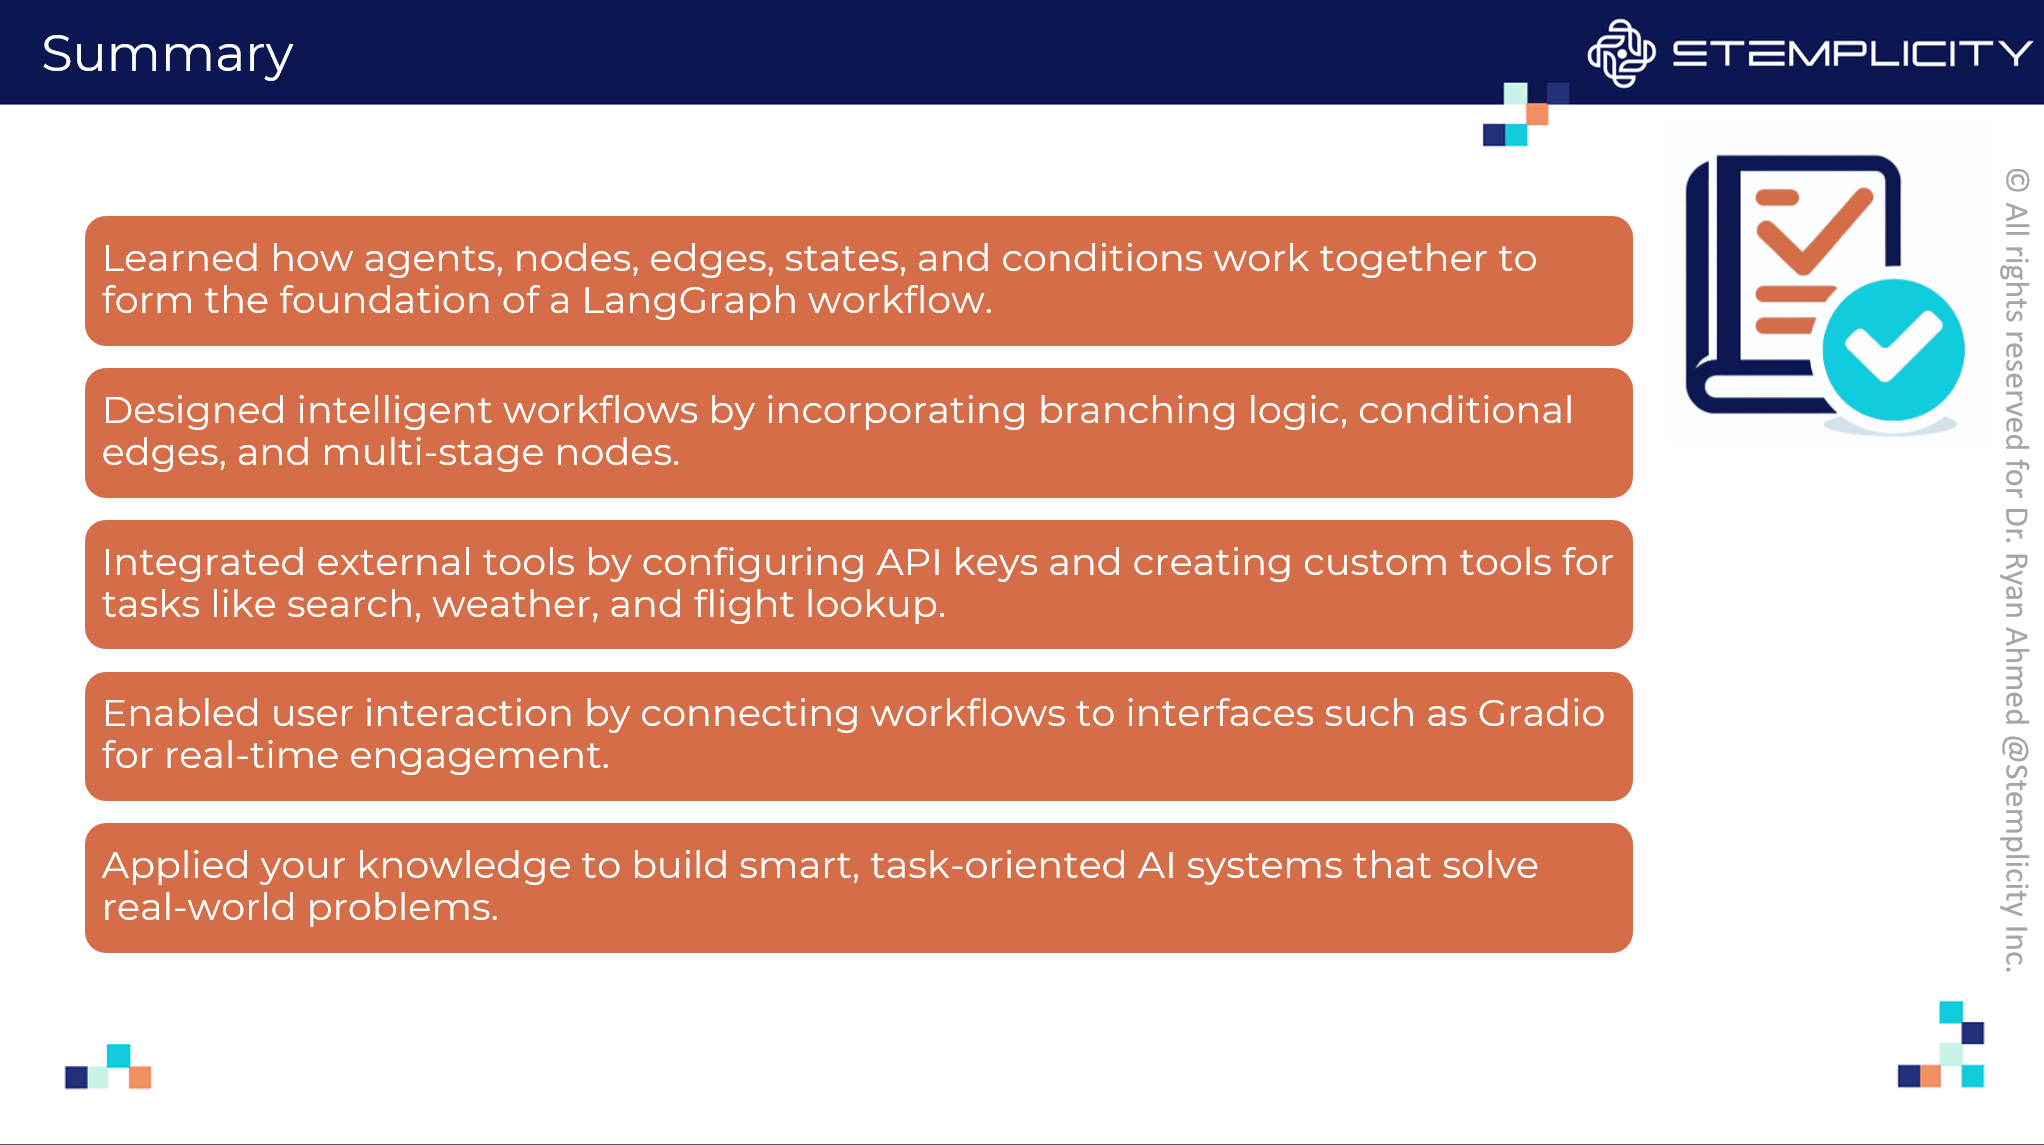

Would love to connect with you on LinkedIn: https://www.linkedin.com/in/dr-ryan-ahmed/

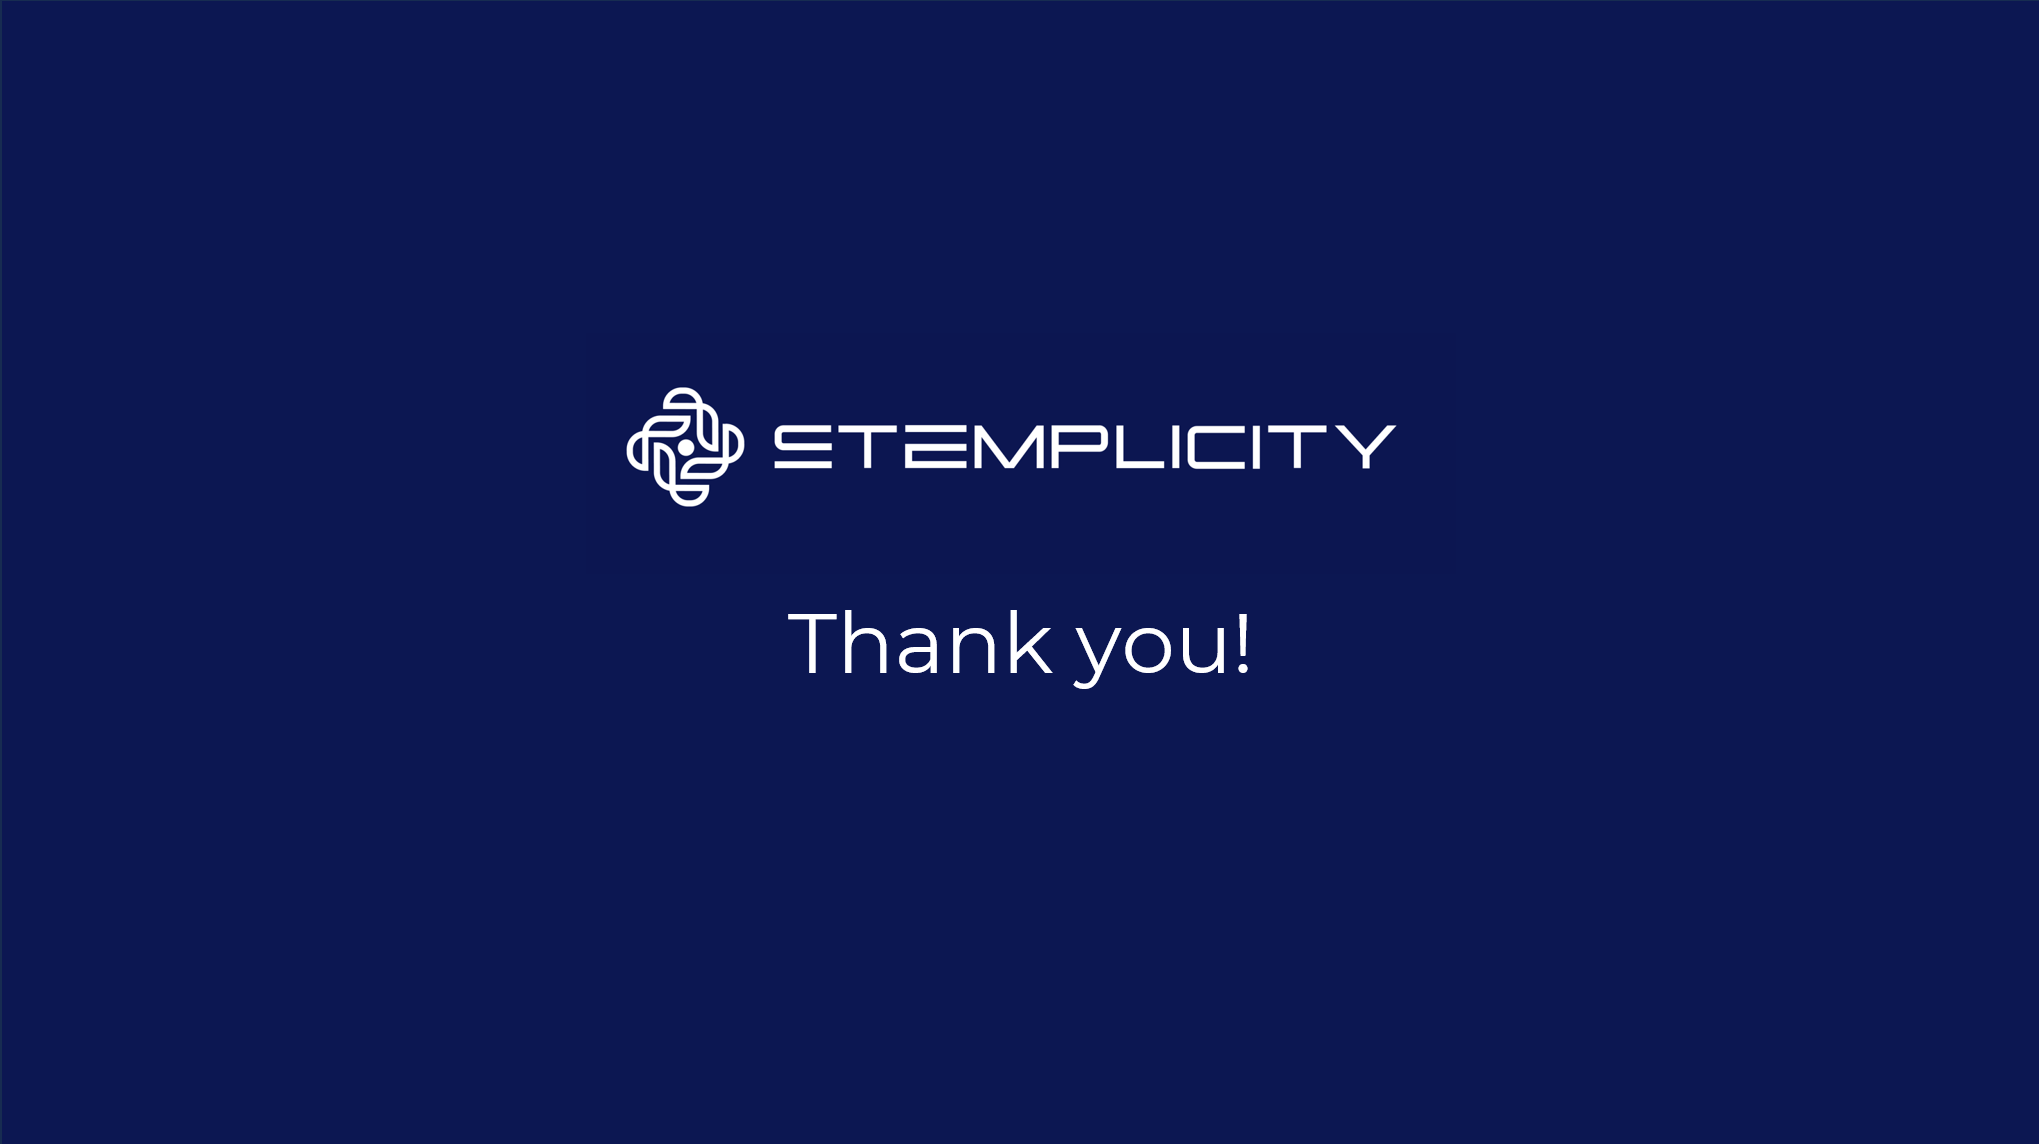